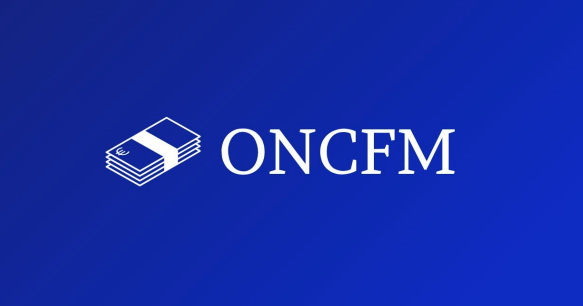
<h1><center> DETECTER DES FAUX BILLETS

## Sommaire <a id="0"></a>


<div class="alert alert-block alert-info" style="margin-top: 10px">

I.  [Analyse descriptive](#1)<br>
        - I.1 [Vue d'ensemble](#1.1)<br>
        - I.2 [Analyse et retraitement des valeurs nulles par regression linéaire](#1.2)<br>
    
II.  [Regression Logistique](#2)<br>
III.  [k-means](#3) <br>
V. [Synthèse](#4)<br>
V. [Validation](#5) <br>

</div>

In [2]:
# import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.linear_model import LinearRegression # OLS
import statsmodels.api as sm
import statsmodels.stats.api as sms
import scipy.stats as stats
from sklearn import preprocessing
from sklearn.cluster import KMeans #clustering K-means
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix,ConfusionMatrixDisplay
from sklearn.metrics import log_loss


In [3]:
#reading files
billets=pd.read_csv('billets.csv', ';')

# I. Analyse descriptive <a id="1"></a>

## I.1 Overview <a id="1.1"></a>

In [4]:
billets.head()

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,True,171.81,104.86,104.95,4.52,2.89,112.83
1,True,171.46,103.36,103.66,3.77,2.99,113.09
2,True,172.69,104.48,103.50,4.40,2.94,113.16
3,True,171.36,103.91,103.94,3.62,3.01,113.51
4,True,171.73,104.28,103.46,4.04,3.48,112.54


In [5]:
billets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   is_genuine    1500 non-null   bool   
 1   diagonal      1500 non-null   float64
 2   height_left   1500 non-null   float64
 3   height_right  1500 non-null   float64
 4   margin_low    1463 non-null   float64
 5   margin_up     1500 non-null   float64
 6   length        1500 non-null   float64
dtypes: bool(1), float64(6)
memory usage: 71.9 KB


In [6]:
df_stats=billets.groupby(['is_genuine']).describe().T

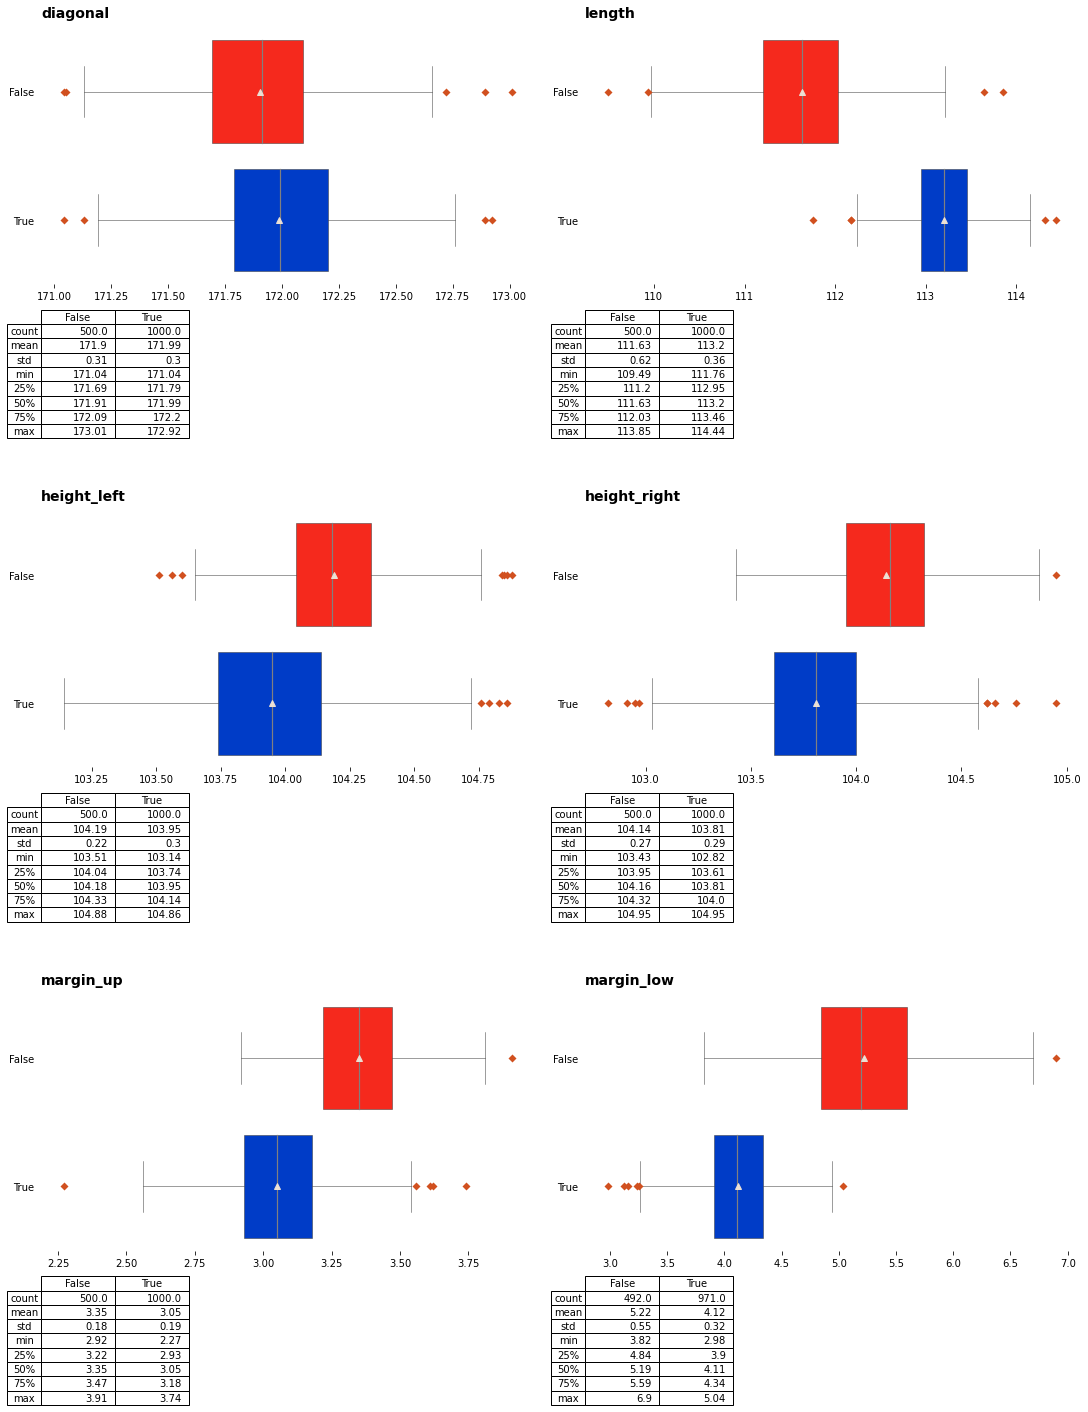

In [7]:

billets_palette={True:'#003CC7',False:'#F5291D'}
flierprops = dict(marker='D', markerfacecolor='#D1501F', markersize=5,markeredgecolor='none')
medianprops = dict(linewidth=1.2, color='grey')
meanpointprops = dict( markeredgecolor='#ECE0D4',
                      markerfacecolor='#ECE0D4')

fig1, ((ax1,ax2),(ax3,ax4),(ax5,ax6)) =plt.subplots(3,2,figsize=(15,20), constrained_layout=True, gridspec_kw=dict( hspace=1))
for axe, col in zip ((ax1,ax2,ax3,ax4,ax5,ax6),["diagonal",'length', 'height_left', 'height_right', 'margin_up', 'margin_low']):
    sns.boxplot(y="is_genuine", x=col, ax=axe,orient='h',data=billets, saturation=1, linewidth=0.5, palette=billets_palette,
            showmeans=True, flierprops=flierprops, medianprops=medianprops, meanprops=meanpointprops)
    axe.set_title(col, loc='left', weight='bold', y=1, pad=10, fontsize=14)


    axe.table(cellText=df_stats.loc[[col]].reset_index().iloc[:,1:].set_index('level_1').values.round(2),
          rowLabels=df_stats.loc[[col]].reset_index().iloc[:,1:].set_index('level_1').index,
          colLabels=df_stats.loc[[col]].reset_index().iloc[:,1:].set_index('level_1').columns,
          cellLoc = 'right', rowLoc = 'center',
          loc='center', bbox=[0,-0.6,.3,.5])
    for location in ['left','right', 'bottom', 'top']:
        axe.spines[location].set_visible(False)
    axe.set_ylabel('')
    axe.set_xlabel('')
    axe.tick_params(left=False)
plt.show()

## I.2 Analyse et traitement des valeurs nulles <a id="1.2"></a>

In [8]:
billets['margin_low'].isnull().sum()

37

In [9]:
billets[billets['margin_low'].isnull()].groupby('is_genuine').count()

,diagonal,height_left,height_right,margin_low,margin_up,length
is_genuine,,,,,,
False,8,8,8,0,8,8
True,29,29,29,0,29,29


On voit qu'il y a 37 valeurs nulles dans 'margin_low' dont 29 sur des vrais billets. 


### Analyse des corrélations

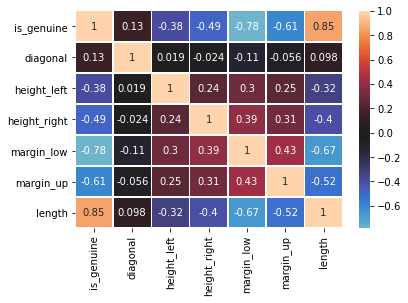

In [10]:
# analyse des corrélations
sns.heatmap(billets.corr(), annot=True, linewidths=.5, center=0)
plt.show()

### Regression linéaire sur les vrais billets

In [11]:
X=billets[(billets['margin_low'].notnull())&(billets['is_genuine']==True)].iloc[:,[1,2,3,5,6]]
y=billets[(billets['margin_low'].notnull())&(billets['is_genuine']==True)].iloc[:,4]

In [12]:
X = sm.add_constant(X) # intercept

In [13]:
model = sm.OLS(y, X)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:             margin_low   R-squared:                       0.008
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     1.544
Date:                Thu, 30 Dec 2021   Prob (F-statistic):              0.174
Time:                        09:21:28   Log-Likelihood:                -264.37
No. Observations:                 971   AIC:                             540.7
Df Residuals:                     965   BIC:                             570.0
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const          -10.4144      7.928     -1.314   

#### Hypothèse d'Homoschedasticité

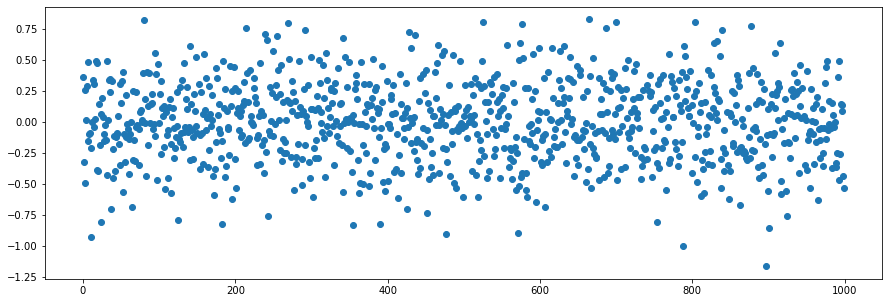

In [14]:
fix, ax=plt.subplots(figsize=(15,5))
plt.scatter(y=results.resid,x=results.resid.to_frame().index)

plt.show()


In [15]:
print('p_value :', sms.het_goldfeldquandt(results.resid, model.exog)[1])

p_value : 0.30158923346080707


Visuellement et aussi grâce au test de goldfelquandt on ne peut pas rejeter l'hypothèse d'homoschedasticité du model

#### Hypothèse de normalité

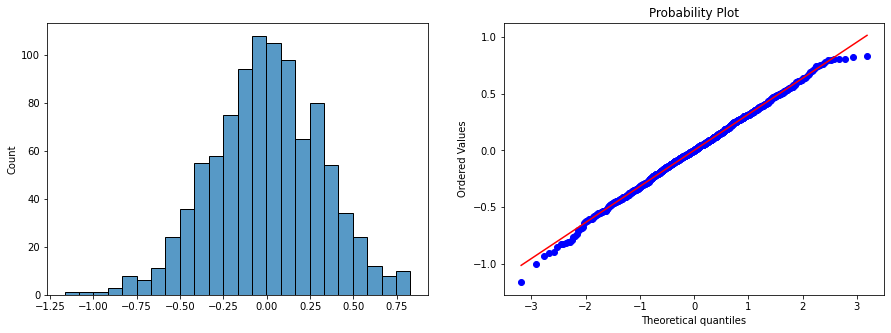

In [16]:
fix, (ax1,ax2)=plt.subplots(1,2,figsize=(15,5))
sns.histplot(results.resid, ax=ax1)
stats.probplot(results.resid, dist="norm", plot=ax2)
plt.show()

### Regression sur les faux billets

In [17]:
X_f=billets[(billets['margin_low'].notnull())&(billets['is_genuine']==False)].iloc[:,[1,2,3,5,6]]
y_f=billets[(billets['margin_low'].notnull())&(billets['is_genuine']==False)].iloc[:,4]

In [18]:
X_f = sm.add_constant(X_f) # intercept

In [19]:
model2 = sm.OLS(y_f, X_f)
results2 = model2.fit()
print(results2.summary())

                            OLS Regression Results                            
Dep. Variable:             margin_low   R-squared:                       0.027
Model:                            OLS   Adj. R-squared:                  0.017
Method:                 Least Squares   F-statistic:                     2.718
Date:                Thu, 30 Dec 2021   Prob (F-statistic):             0.0195
Time:                        09:21:30   Log-Likelihood:                -399.85
No. Observations:                 492   AIC:                             811.7
Df Residuals:                     486   BIC:                             836.9
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           20.2920     20.068      1.011   

#### Hypothèse d'Homoschedasticité

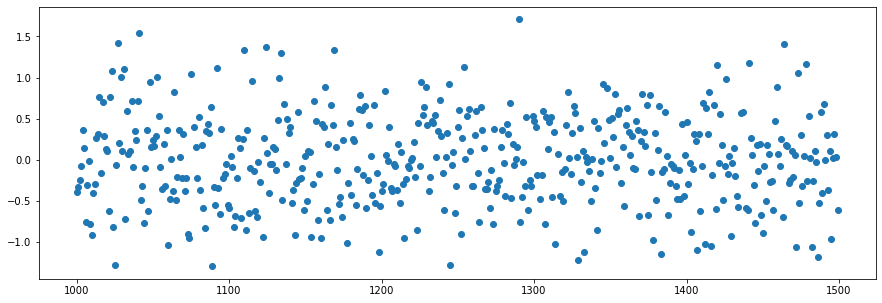

In [20]:
fix, ax=plt.subplots(figsize=(15,5))
plt.scatter(y=results2.resid,x=results2.resid.to_frame().index)

plt.show()


In [21]:
print('p_value :', sms.het_goldfeldquandt(results2.resid, model2.exog)[1])

p_value : 0.8564380539242336


Visuellement et aussi grâce au test de goldfelquandt on ne peut pas rejeter l'hypothèse d'homoschedasticité du model

#### Hypothèse de normalité

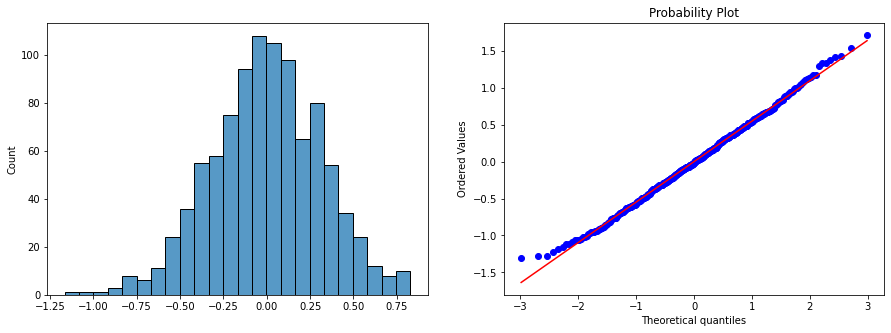

In [22]:
fix, (ax1,ax2)=plt.subplots(1,2,figsize=(15,5))
sns.histplot(results.resid, ax=ax1)
stats.probplot(results2.resid, dist="norm", plot=ax2)
plt.show()

### Remplacement des valeurs nulles

In [23]:
X_null_v=billets[(billets['margin_low'].isnull())&(billets['is_genuine']==True)].iloc[:,[1,2,3,5,6]]
X_null_v = sm.add_constant(X_null_v)

In [24]:
X_null_f=billets[(billets['margin_low'].isnull())&(billets['is_genuine']==False)].iloc[:,[1,2,3,5,6]]
X_null_f = sm.add_constant(X_null_f)

In [25]:
billets.loc[(billets['margin_low'].isnull())&(billets['is_genuine']==True),'margin_low']=results.predict(X_null_v)

In [26]:
billets.loc[(billets['margin_low'].isnull())&(billets['is_genuine']==False),'margin_low']=results2.predict(X_null_f)

In [27]:
billets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   is_genuine    1500 non-null   bool   
 1   diagonal      1500 non-null   float64
 2   height_left   1500 non-null   float64
 3   height_right  1500 non-null   float64
 4   margin_low    1500 non-null   float64
 5   margin_up     1500 non-null   float64
 6   length        1500 non-null   float64
dtypes: bool(1), float64(6)
memory usage: 71.9 KB


## Visualisation après retraitement

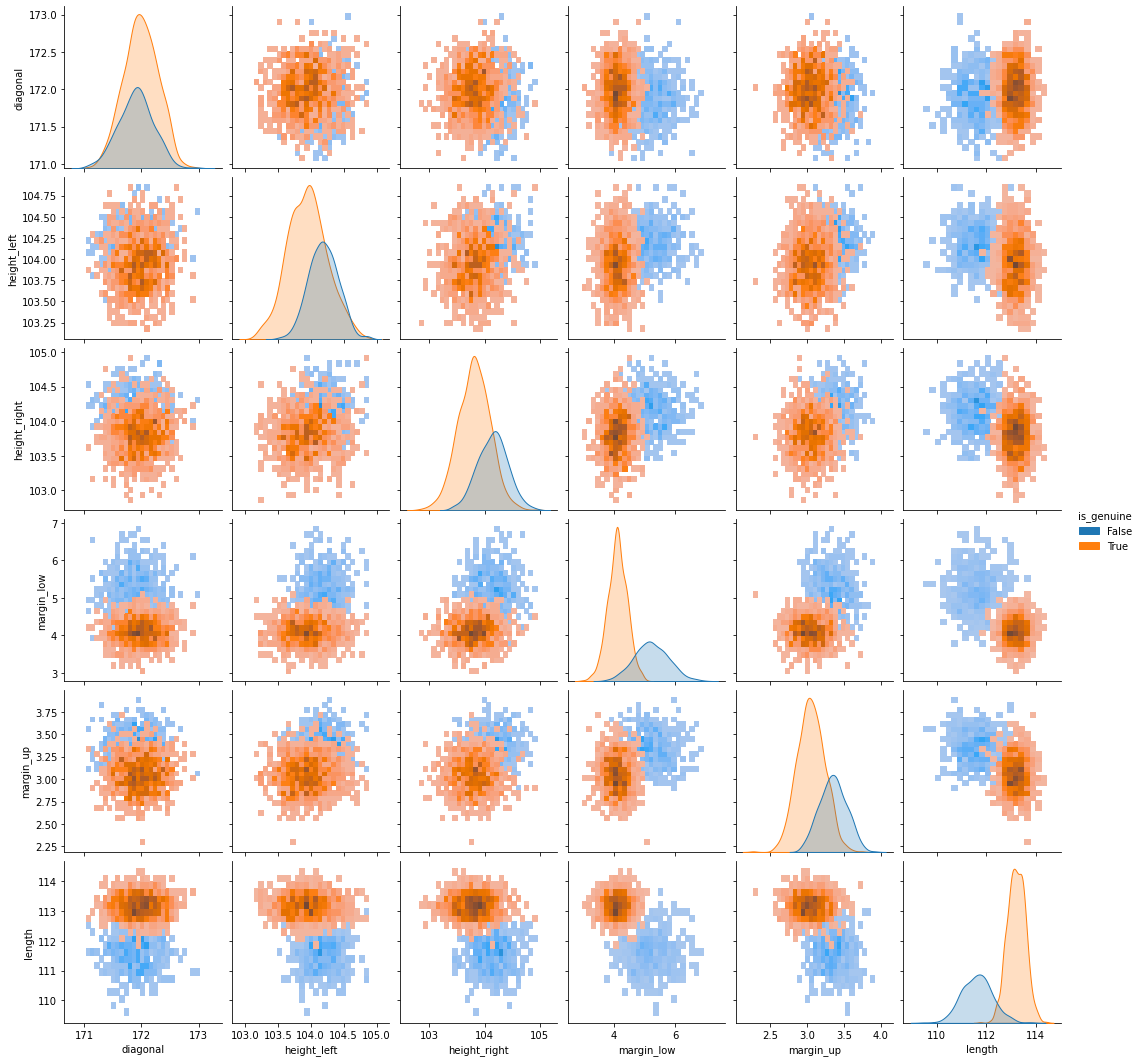

In [28]:
sns.pairplot(data=billets, hue='is_genuine', kind="hist", diag_kind='kde')
plt.show()

# II.  Regression Logistique <a id="2"></a>

In [29]:
X = billets.iloc[:,1:]
X = preprocessing.StandardScaler().fit(X).transform(X)

In [30]:
y=np.asarray(billets['is_genuine']).astype('int')

In [31]:
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=4)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (1200, 6) (1200,)
Test set: (300, 6) (300,)


In [32]:
LogitR = LogisticRegression(C=0.01, solver='liblinear').fit(X_train,y_train)
LogitR

LogisticRegression(C=0.01, solver='liblinear')

In [33]:
yhat = LogitR.predict(X_test)

In [34]:
yhat_prob = LogitR.predict_proba(X_test) # probabilités par classe

In [35]:
cnf_matrix = confusion_matrix(y_test, yhat, labels=[1,0])

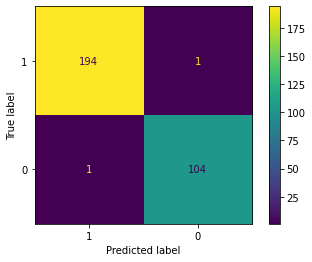

In [36]:
disp = ConfusionMatrixDisplay(confusion_matrix=cnf_matrix,
                              display_labels=[1,0])
disp.plot()
plt.show()

In [37]:
print (classification_report(y_test, yhat))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       105
           1       0.99      0.99      0.99       195

    accuracy                           0.99       300
   macro avg       0.99      0.99      0.99       300
weighted avg       0.99      0.99      0.99       300



# III. K-means <a id="3"></a>

In [38]:
clustering_Kmeans = KMeans(n_clusters=2, n_init=1, init='random').fit(X_train)

In [39]:
yhat = clustering_Kmeans.predict(X_test)

In [40]:
cnf_matrix = confusion_matrix(y_test, yhat, labels=[1,0])

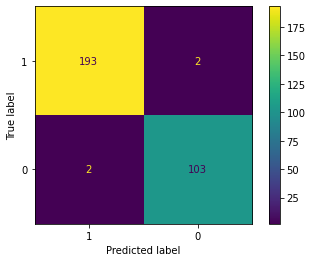

In [41]:
disp = ConfusionMatrixDisplay(confusion_matrix=cnf_matrix,
                               display_labels=[1,0])
disp.plot()
plt.show()

# IV - Synthèse  <a id="4"></a>

L'algorithme de classification donne un résultat légèrement supérieur à celui de clustering. De plus il a l'avantage de pouvoir donner une probabilité d'appartenance à chaque classe.

# V - Validation <a id="5"></a>

In [42]:
#reading files
billets_prod=pd.read_csv('billets_testt.csv')

In [43]:
billets_prod

,diagonal,height_left,height_right,margin_low,margin_up,length,id
0,172.09,103.95,103.73,4.39,3.09,113.19,B_1
1,171.52,104.17,104.03,5.27,3.16,111.82,B_2
2,171.78,103.80,103.75,3.81,3.24,113.39,B_3
3,172.02,104.08,103.99,5.57,3.30,111.10,B_4
4,171.79,104.34,104.37,5.00,3.07,111.87,B_5


In [44]:
X_val = billets_prod.iloc[:,:-1]
X = billets.iloc[:,1:]
X_val = preprocessing.StandardScaler().fit(X).transform(X_val)

In [45]:
yhat_val = LogitR.predict(X_val)
yhat_val_prob = LogitR.predict_proba(X_val)

In [46]:
billets_prod['is_genuine'] = yhat_val
billets_prod['Proba billet faux'] = [x[1] for x in yhat_val_prob]
billets_prod

,diagonal,height_left,height_right,margin_low,margin_up,length,id,is_genuine,Proba billet faux
0,172.09,103.95,103.73,4.39,3.09,113.19,B_1,1,0.850644
1,171.52,104.17,104.03,5.27,3.16,111.82,B_2,0,0.148783
2,171.78,103.80,103.75,3.81,3.24,113.39,B_3,1,0.910714
3,172.02,104.08,103.99,5.57,3.30,111.10,B_4,0,0.051628
4,171.79,104.34,104.37,5.00,3.07,111.87,B_5,0,0.174572
